<a href="https://www.kaggle.com/code/adri1g/predict-solar-irradiance?scriptVersionId=183520711" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predict solar irradiance (GHI)
Also call GHI (Global Horizontal Irradiance), in W/m². This is the target feature (y) used to predict electricity generation (W) from solar panels.

$$
GHI = DNI * cos(\theta) + DHI
$$

$\theta$ : incidence of the solar beam

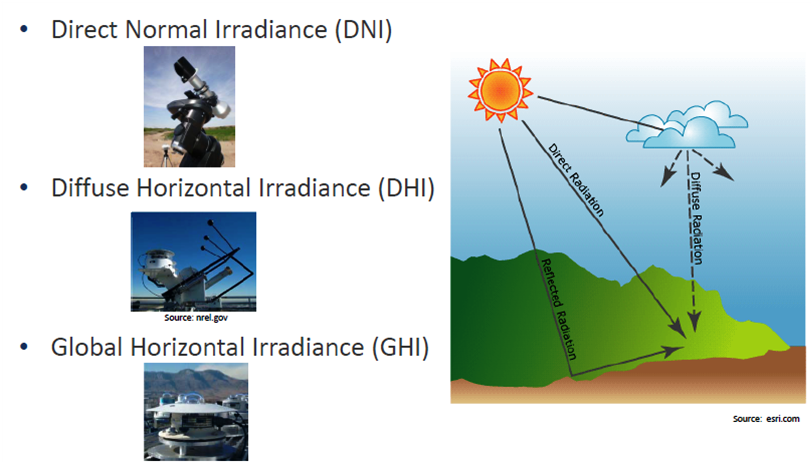

From : https://firstgreenconsulting.wordpress.com/2012/04/26/differentiate-between-the-dni-dhi-and-ghi/

We will use a data set from the NSRDB. These are satellite meteorological measurements.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as skl
import os

from scipy import stats

from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)


# Import weather files

In [2]:
print("File location using os.getcwd():", os.getcwd())

# default path for local execution on PC
PATH = 'nsrdb-tours/' # input folder
WORK_DIR = PATH  # output folder

if "google.colab" in str(get_ipython()):
    print("Running on CoLab")
    PATH = "/content/drive/My Drive/Colab Notebooks/time_series/"  # input
    WORK_DIR = PATH  # output

    # mount like on Linux
    from google.colab import drive

    drive.mount("/content/drive")

elif "kaggle" in str(os.getcwd()):
    PATH = "/kaggle/input/nsrdb-tours/"  # input
    WORK_DIR = "/kaggle/working/darts_logs/"  # output
    from learntools.time_series.utils import *
    from learntools import *
    
else: # on local PC
    from ds_utils import *
    from ds_time_series import *

File location using os.getcwd(): /kaggle/working


## Concatenate and convert datetime to index

In [3]:
# Define the latitude and longitude values
latitude = '47.41'
longitude = '0.70'

# Define the base name of the CSV files
base_name = PATH + f'359516_{latitude}_{longitude}_'

# List of years
years = [2017, 2018, 2019]

# Initialize an empty list to hold DataFrames
dfs = []

# Loop over the years, read the CSV files and process them
for year in years:
    # Create the full file name
    file_name = base_name + str(year) + '.csv'
    print(file_name)
    # Read the CSV file
    df = pd.read_csv(file_name, skiprows=2)
    
    # Append the processed DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list into a whole dataset
df = pd.concat(dfs)

# Generate a datetime index column
df['datetime'] = pd.to_datetime(df['Year'].astype(str) +'-'
                                + df['Month'].astype(str) + '-'
                                + df['Day'].astype(str) + ' '
                                + df['Hour'].astype(str) + ':'
                                + df['Minute'].astype(str) + ':00')

# Drop useless columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1)

# Set datetime as index
df = df.set_index('datetime')

# accelerate processing by reducing information
# df = df.astype(np.float32)

df.info()  # check dataframe info

/kaggle/input/nsrdb-tours/359516_47.41_0.70_2017.csv
/kaggle/input/nsrdb-tours/359516_47.41_0.70_2018.csv
/kaggle/input/nsrdb-tours/359516_47.41_0.70_2019.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105120 entries, 2017-01-01 00:00:00 to 2019-12-31 23:45:00
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Temperature         105120 non-null  float64
 1   Clearsky DHI        105120 non-null  int64  
 2   Clearsky DNI        105120 non-null  int64  
 3   Clearsky GHI        105120 non-null  int64  
 4   Cloud Type          105120 non-null  int64  
 5   Dew Point           105120 non-null  float64
 6   DHI                 105120 non-null  int64  
 7   DNI                 105120 non-null  int64  
 8   Fill Flag           105120 non-null  int64  
 9   GHI                 105120 non-null  int64  
 10  Ozone               105120 non-null  float64
 11  Relative Humidity   105120 non-null  floa

In [4]:
STEPS_PER_DAY = 24 * 4  # 24 hours * 4 steps per hour

In [5]:
# Rename the values in the "Cloud Type" column
cloud_type_mapping = {
   0:  'Clear',
   1:  'Probably Clear',
   2:  'Fog',
   3:  'Water',
   4:  'Super-Cooled Water',
   5:  'Mixed',
   6:  'Opaque Ice',
   7:  'Cirrus',
   8:  'Overlapping',
   9:  'Overshooting',
   10: 'Unknown',
   11: 'Dust',
   12: 'Smoke',
   -15:'N/A',
}
df['Cloud Type Name'] = df['Cloud Type'].map(cloud_type_mapping)

fill_flag_mapping = {
    0: 'N/A',
    1: 'Missing Image',
    2: 'Low Irradiance',
    3: 'Exceeds Clearsky',
    4: 'Missing Cloud Properties',
    5: 'Rayleigh Violation'
}

df['Fill Flag Name'] = df['Fill Flag'].map(fill_flag_mapping)

# Features engineering
* y: target to predict (GHI)
* X: features used to predict y

Determine which features to use in X.

## Solar zenith and altitude angle

We use deterministic astronomical data to obtain forwards information on the angular altitude of the sun during the day and during the year.

* Zenith angle, between the sun’s rays and the vertical direction
* Altitude angle from 0 (no sun) to 90

Get solar angle: https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.solarposition.get_solarposition.html

<img src="https://www.mdpi.com/sensors/sensors-21-06259/article_deploy/html/images/sensors-21-06259-g002.png" alt= “” width="750" height="value">

CC BY 4.0 Zhang et al.
DOI:10.3390/s21186259

https://nsrdb.nrel.gov/data-sets/us-data

In [6]:
#rotation to convert from zenith angle to solar altitude
df['Solar Altitude Angle'] = 90 - df['Solar Zenith Angle']

#the sun is down when the angle is under 0 (the horizon)
df.loc[df['Solar Altitude Angle'] <= 0, 'Solar Altitude Angle'] = 0

#determine periods of sunlight from the solar position
daylight = df['Solar Zenith Angle'] <= 90
# convert to int to use with various prediction model
df["daylight"] = (daylight).astype(int)

### Day light per month
Use boxplot to vizualise solar irradiance (GHI) per month.

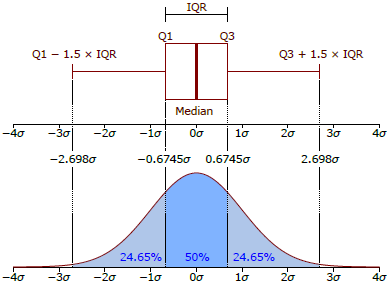

IQR: inter quartile range

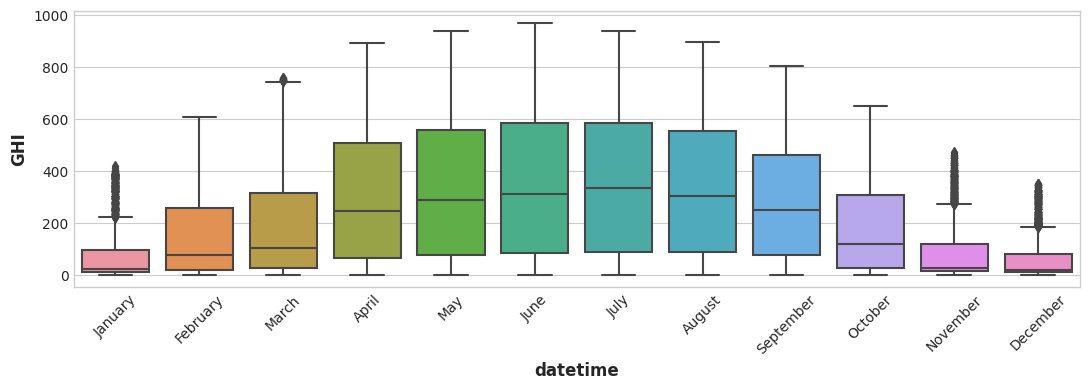

In [7]:
sns.boxplot(x=df[daylight].index.month_name(), y='GHI', data=df[daylight])
plt.xticks(rotation=45)
plt.show()

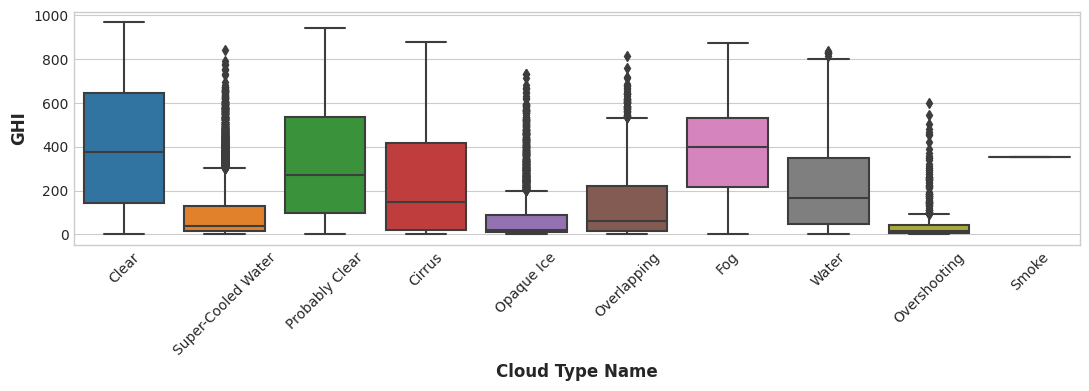

In [8]:
sns.boxplot(x='Cloud Type Name', y='GHI', data=df[daylight])
plt.xticks(rotation=45)
plt.show()

The cloud cover determined by satellite does not appear to have an high impact on the GHI, and more important, this feature is absent in production.

## Mutual information for GHI

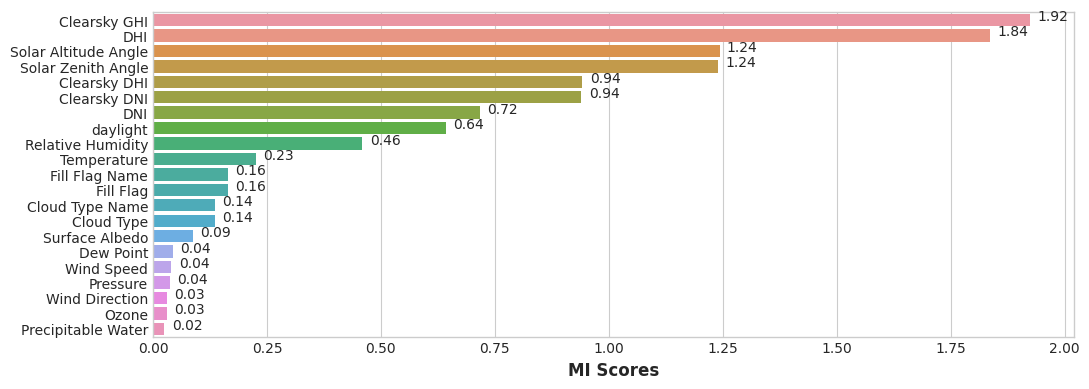

In [9]:
def make_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Compute mutual information scores for features in X relative to target y.
    Example:
    make_mi_scores(df.drop("y", axis=1), df["y"])
    """
    from sklearn.feature_selection import mutual_info_regression
    
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=0
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

def plot_scores(scores: pd.Series, score_type: str):
    scores = scores.sort_values(ascending=False)  # Seaborn prefers this orientation
    sns.barplot(x=scores, y=scores.index)

    if score_type == "mi":
        plt.xlabel("Mutual Information Scores")
    elif score_type == "corr":
        plt.xlabel("Correlation Scores")

    # Add a text label to each bar with the corresponding score
    for i, score in enumerate(scores):
        plt.text(score + 0.05, i, f"{score:.2f}", ha="center")

mi_scores = make_mi_scores(df.drop("GHI", axis=1), df["GHI"])
plot_scores(mi_scores, "Mutual Information Scores")

#https://pvlib-python.readthedocs.io/en/stable/reference/clearsky.html

Solar angle and daylight from astronomical parameters are strongly related to GHI. Humidity and Temperature are less related to GHI.

## Correlation between GHI and features

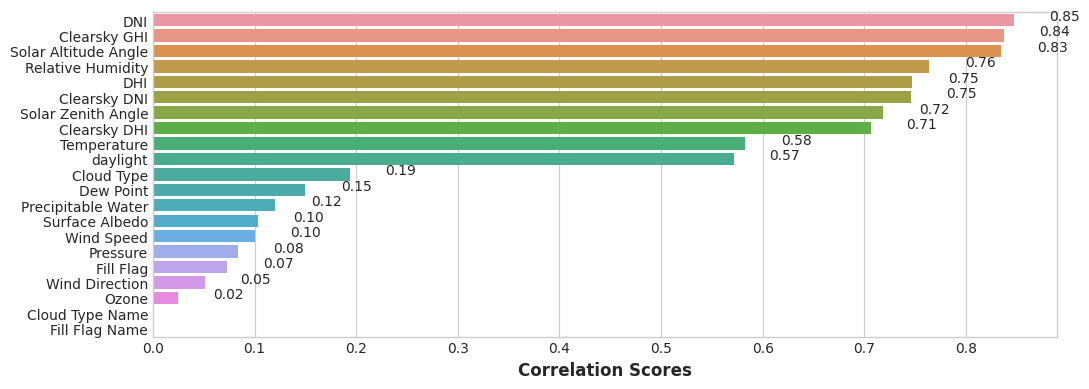

In [10]:
def make_corr_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Compute correlation scores for features in X relative to target y."""
    # Check the data types of the columns in X and y
    X_numeric = X.select_dtypes(include=['number'])
    y_numeric = y.to_frame().select_dtypes(include=['number'])

    # If y is not numeric, raise an error
    if y_numeric.empty:
        raise ValueError("Target variable y must be numeric")

    # Compute the correlation scores for the numeric columns in X
    corr_scores = X_numeric.corrwith(y_numeric.iloc[:,0])
    corr_scores = pd.Series(corr_scores, name="Correlation Scores", index=X.columns)
    corr_scores = corr_scores.abs().sort_values(ascending=False)
    return corr_scores

corr_scores = make_corr_scores(df.drop("GHI", axis=1), df["GHI"])
plot_scores(corr_scores, "corr")

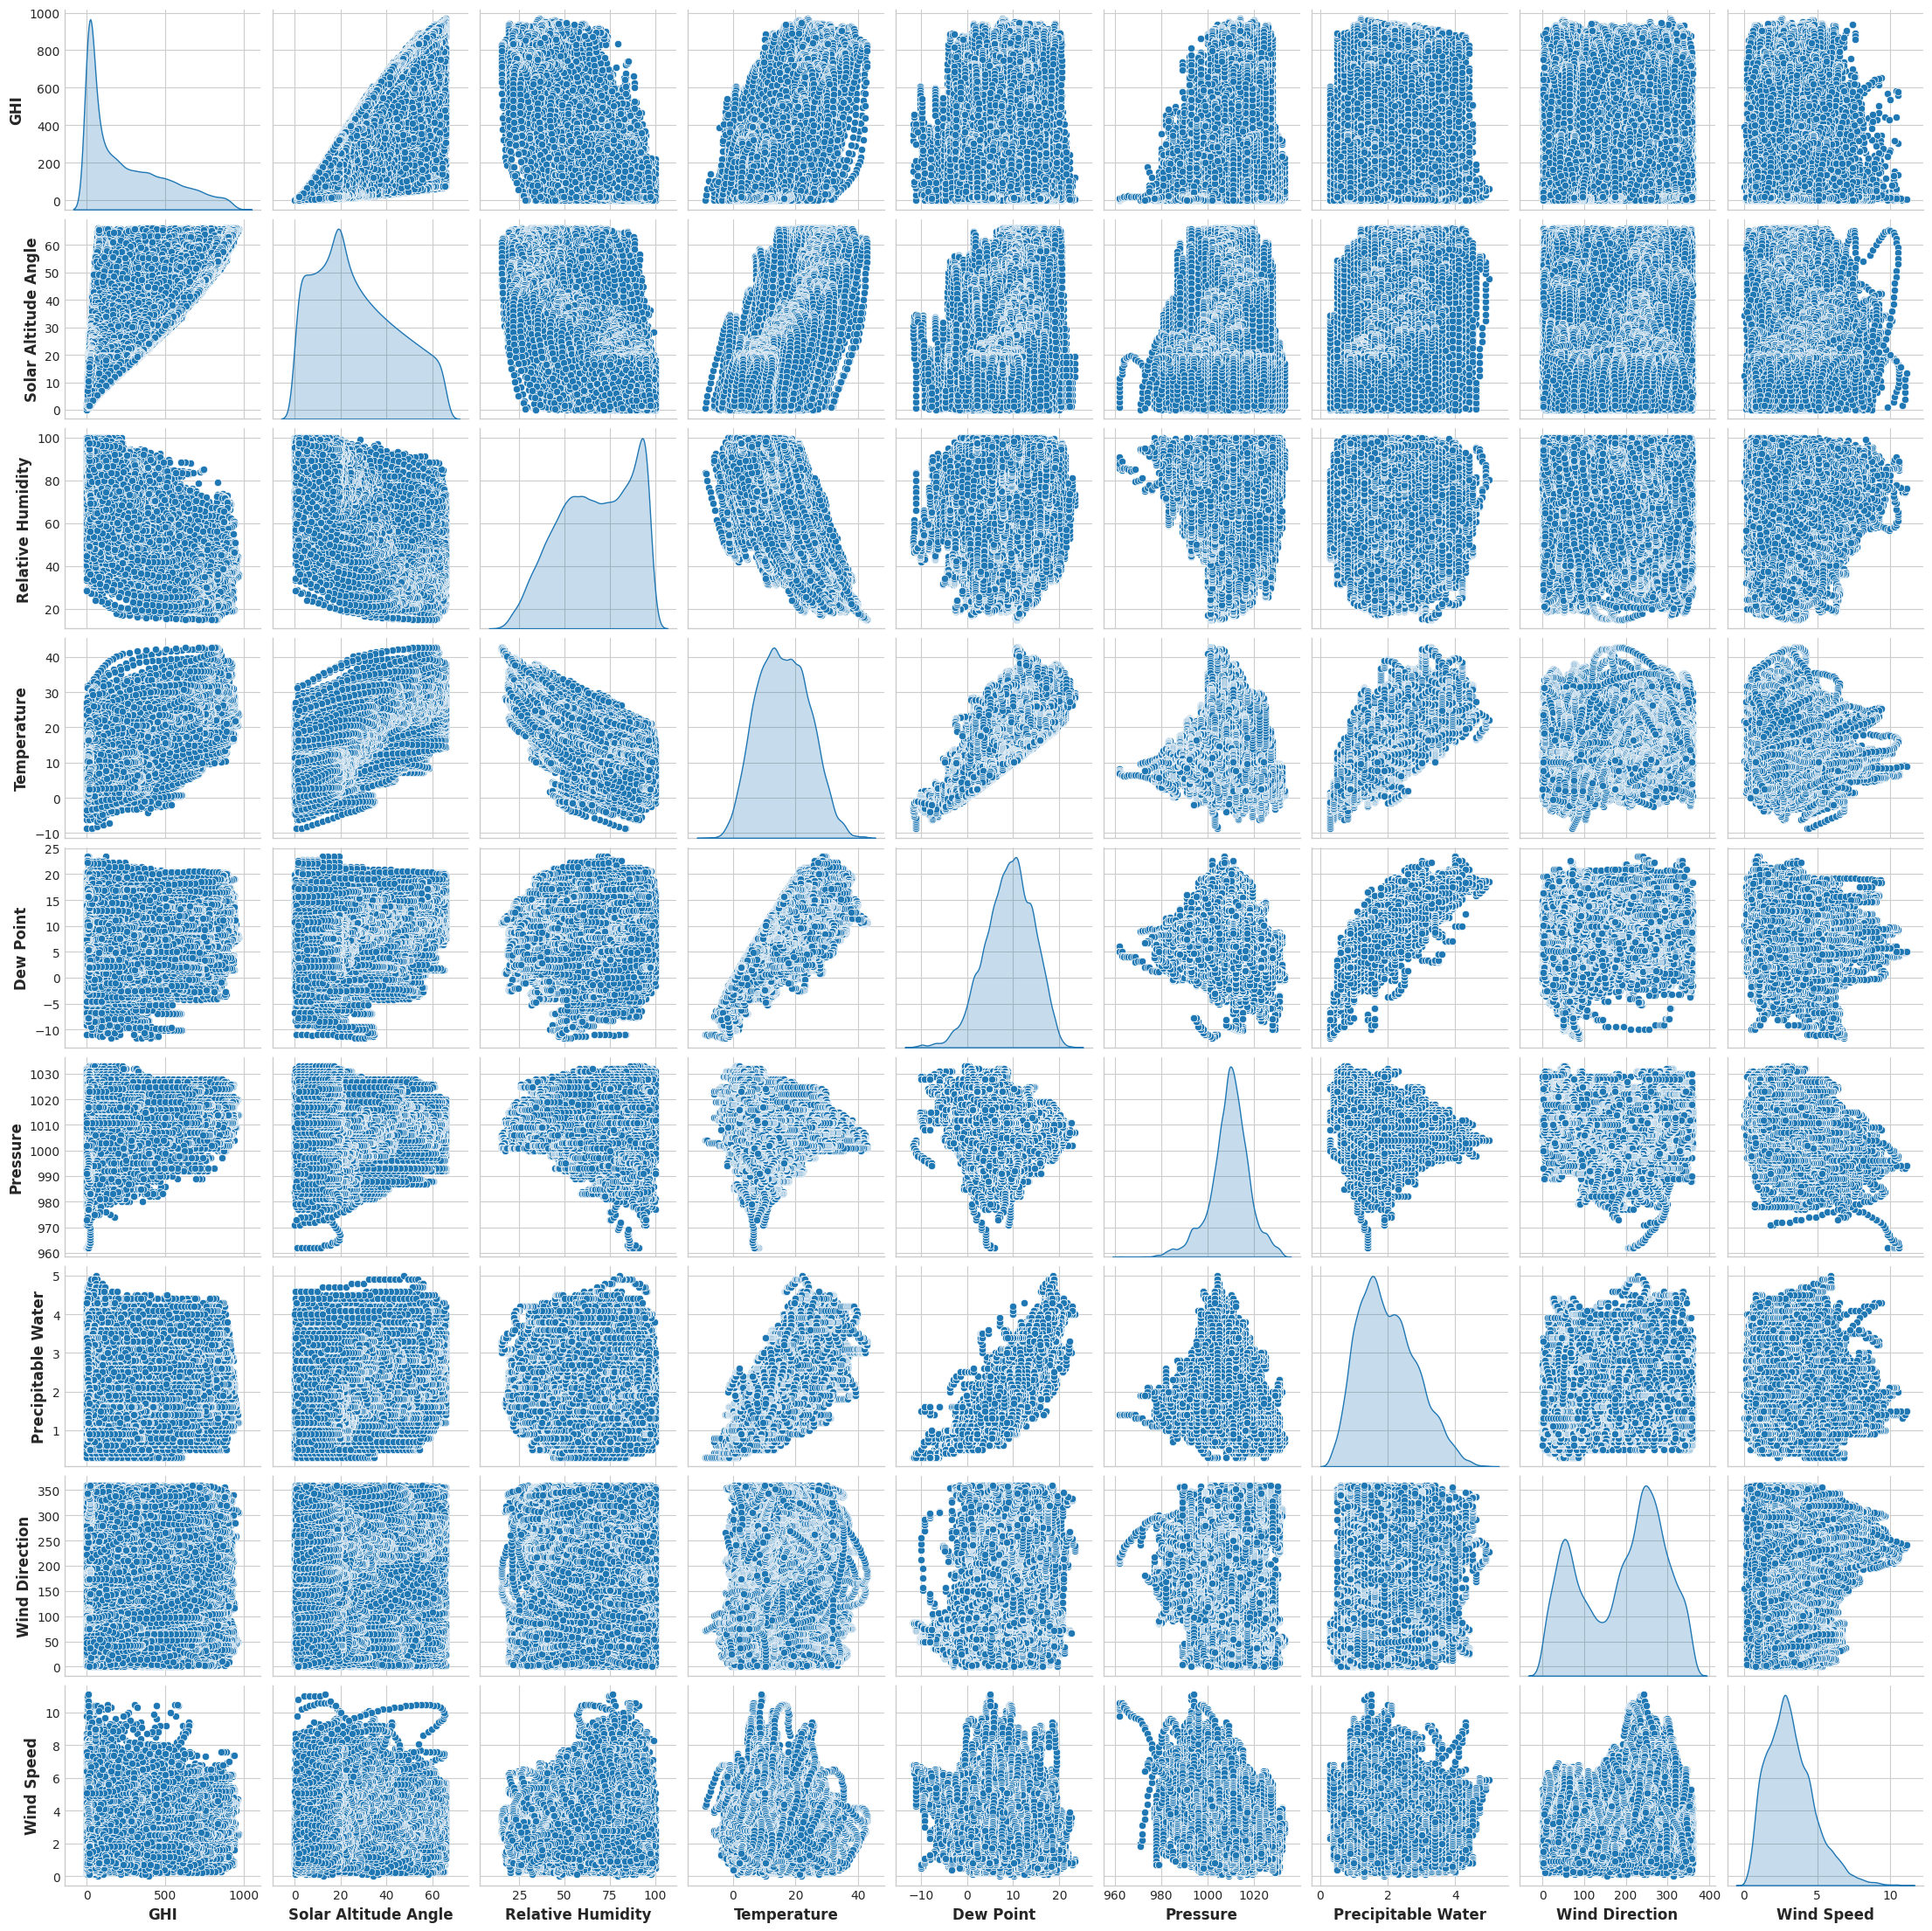

In [11]:
sns.pairplot(df[df["daylight"]==1][[
    "GHI",
    "Solar Altitude Angle",
    "Relative Humidity",
    "Temperature",
    "Dew Point",
    "Pressure",
    "Precipitable Water",
    "Wind Direction",
    "Wind Speed",
]], 
             diag_kind="kde"
             #, corner=True
            )

In [12]:
# Create Fourier features from solar angle
# creates a non-ambiguous feature (a pair of values for each angle) that can be interpreted by the models
df["sin_solar_altitude"] = np.sin(df["Solar Altitude Angle"] * np.pi / 180)
df["cos_solar_altitude"] = np.cos(df["Solar Altitude Angle"] * np.pi / 180)

## Seasonality

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

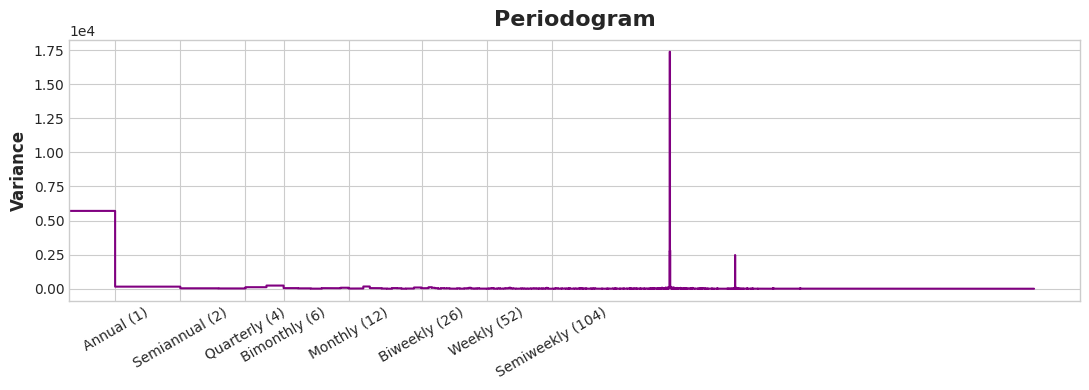

In [13]:
def plot_periodogram(
    ts, fs=pd.Timedelta("365D") / pd.Timedelta("1D"), detrend="linear", ax=None
):
    # Import the periodogram function from the scipy.signal module
    from scipy.signal import periodogram

    # Calculate the sampling frequency: the number of samples per unit of time
    # In this case, the unit of time is 1 day, and the number of samples is 365 days (1 year)

    # The scaling argument is used to specify the type of scaling to apply to the periodogram
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,  # sampling frequency, the number of samples per unit of time
        detrend=detrend,
        window="boxcar",  # the type of window function to apply to the time series
        scaling="spectrum",  # the type of scaling to apply to the periodogram
    )

    # If ax is not provided, create a new subplot
    if ax is None:
        _, ax = plt.subplots()

    # Plot the periodogram: x=freqencies, y=spectrum
    # The step function is used to create a step plot, which is a type of plot that shows the change in a value over a certain period of time
    ax.step(freqencies, spectrum, color="purple")

    # Set the x-axis to a logarithmic scale
    ax.set_xscale("log")

    # Set the x-axis ticks and labels
    # The ticks are the values at which the labels are placed
    # The labels are the text that is displayed at the ticks
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,  # the angle of rotation of the labels
    )

    # Set the y-axis labels to display in scientific notation
    ax.ticklabel_format(
        axis="y", style="sci", scilimits=(0, 0)
    )  # the range of values to display in scientific notation

    # Set the y-axis label
    ax.set_ylabel("Variance")

    # Set the title of the plot
    ax.set_title("Periodogram")

    # Return the axes object
    return ax
plot_periodogram(df["GHI"][:365*24*4].values, 365*24*4)

Annual seasonality is important at ordre 1 like daily seasonality at order 1, no need of additional fourier features.

In [14]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourierYear = CalendarFourier(freq="A", order=1)  # sin/cos pairs for Annual seasonality
fourierDay = CalendarFourier(freq="D", order=1)  # sin/cos pairs for daily seasonality

dp = DeterministicProcess(
    index=df["GHI"].index,
    #period=24*4,
    #constant=True,               # dummy feature for bias (y-intercept)
    #order=1,                     # trend (order 1 means linear)
    #seasonal=True,               # daily seasonality from period (indicators)
    additional_terms=[fourierYear],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_years = dp.in_sample()  # create features for dates in tunnel.index


dp = DeterministicProcess(
    index=df["GHI"].index,
    additional_terms=[fourierDay],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_days = dp.in_sample()  # create features for dates in tunnel.index

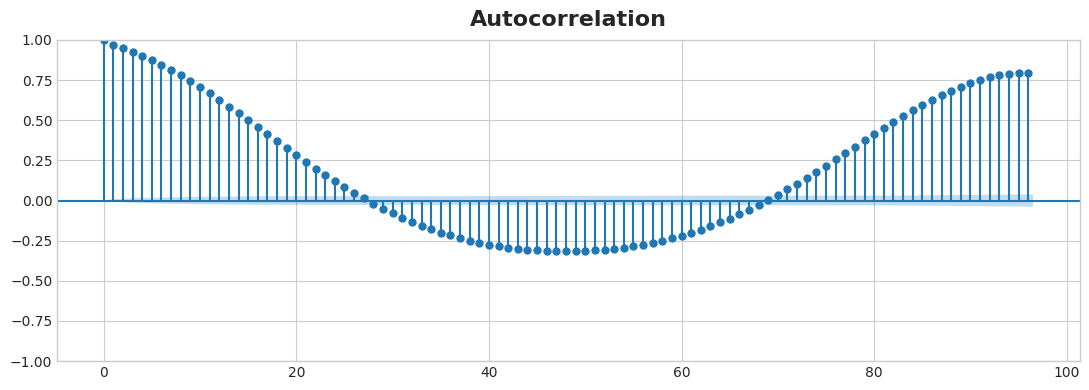

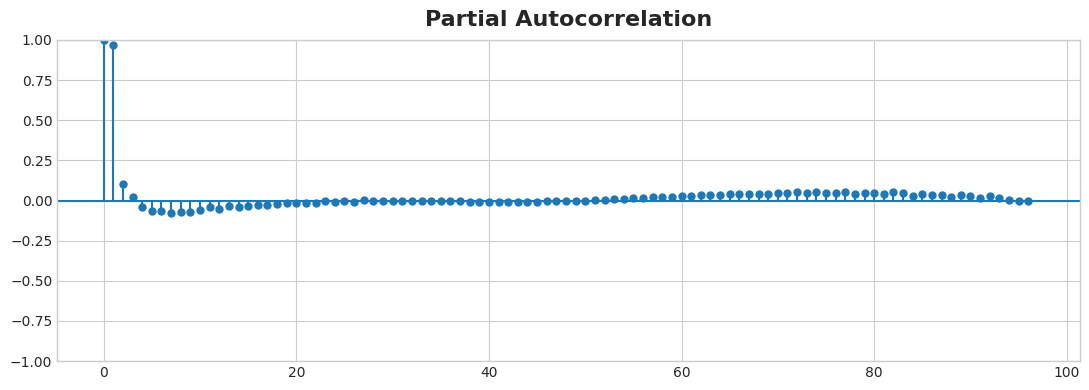

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["GHI"], lags=4*24);

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df["GHI"], lags=4*24);

In [16]:
features_astronomical = [
    "sin_solar_altitude", # Solar Altitude Angle
    "cos_solar_altitude", # Solar Altitude Angle
    "daylight",
]

features_weather = [
    "Relative Humidity",
    "Temperature",
    "Dew Point",
    "Pressure",
    "Precipitable Water",
    "Wind Direction",
    "Wind Speed",
]

In [17]:
y = df["GHI"]
X = df[features_astronomical]

HORIZON_LAGS = 4*24
HORIZON_LEADS = 4*24
#past values of target y
y_lags = make_lags(y, lags=HORIZON_LAGS).bfill()

#futures values from astronomy
X_leads = make_leads(df[features_astronomical], leads=HORIZON_LEADS)

# make y multistep
y = make_multistep_target(y, steps=HORIZON_LEADS).dropna()

# concatenate features in the same X
#X = pd.concat([X, y_lags, X_leads], axis=1).dropna()

# Align y with X on the index (row labels) and unpack the aligned objects back into y and X.
#y, X = y.align(X, axis=0, join='inner') # inner avoid na values on na axis

## Feature using measurements averaged over the last n days

In [52]:
#make lags from previous daily mean value

# Resample to daily frequency and filter based on daylight condition
GHI_mean_day = y[df["daylight"]==1].resample('D').mean().rename(columns={'GHI': 'GHI_mean_day'})
#plot_acf(GHI_mean_day, lags=4*24);
#plot_pacf(GHI_mean_day, lags=4*24);

X_lags_mean = make_lags(GHI_mean_day, lags=3) # make lags of mean
df_dummy = pd.DataFrame(y.index).set_index("datetime") # define a dummy df to restore previous index
X_lags_mean = pd.concat([X_lags_mean, df_dummy], axis=1) # one GHI mean per day
X_lags_mean = X_lags_mean.ffill().dropna() # forward fill to mean for a whole day

#ax = X_lags_mean['y_lag_1', 'GHI_mean_day'][:1000].plot(color='blue')
#y[:1000].plot(ax=ax, color='red')

## Clustering data to extract label and cluster distance as additional features

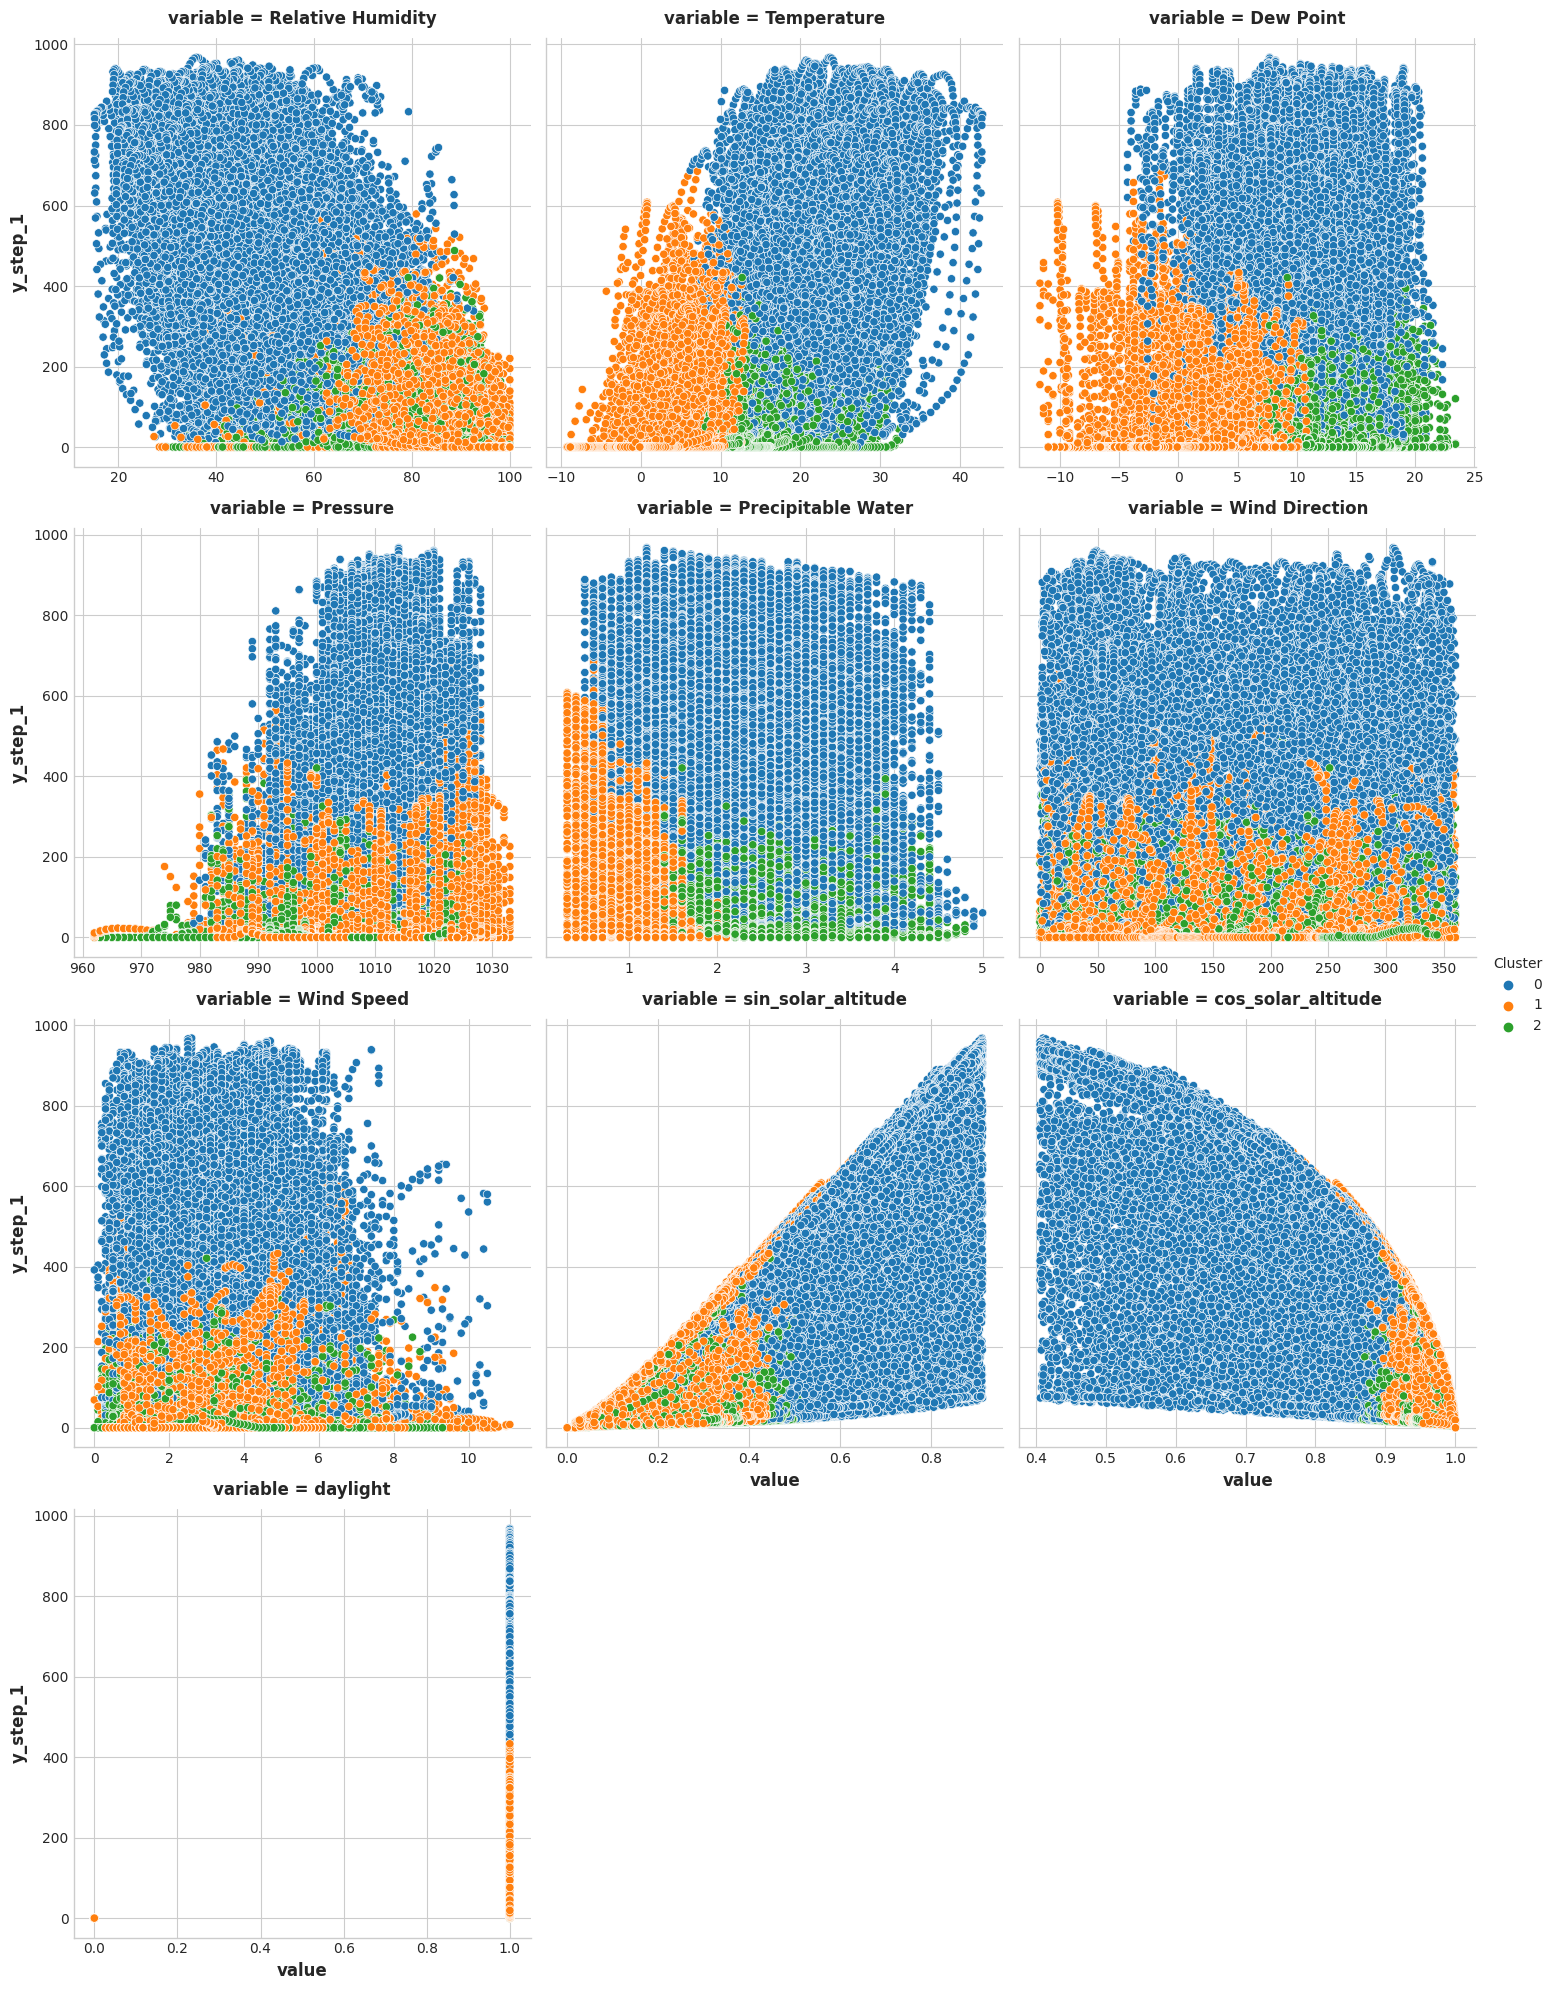

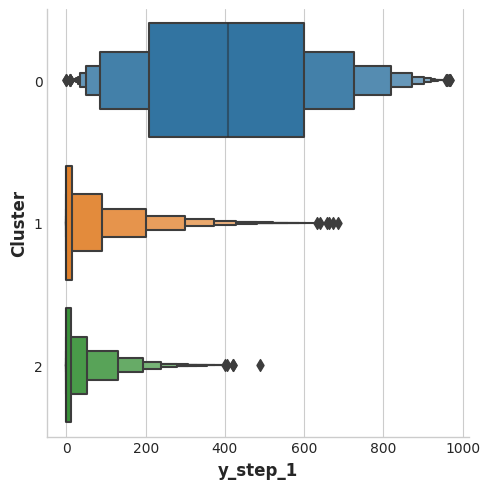

In [67]:
#make features with clustering
#WARNING: data leakage because test data is used to clustering

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Xy = X.copy()
Xy = df[features_weather + features_astronomical]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(Xy.values), columns=Xy.columns)

# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=3, random_state=None)  # , n_init=10
Xy["Cluster"] = kmeans.fit_predict(X_scaled.values)

# Convert Cluster to category
Xy["Cluster"] = Xy["Cluster"].astype("category")

X_cd = kmeans.transform( #clusters distance
    X_scaled.values
)  # each row contains the distance to each centroid
# Label features and join to dataset
columns_centroid = [f"Centroid_{i}" for i in range(X_cd.shape[1])]
X_cd = pd.DataFrame(
    X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])], index=Xy.index
)

Xy[y.columns[0]] = y.iloc[ :, 0]
sns.relplot(
    x="value",
    y=y.columns[0],
    hue="Cluster",
    col="variable",
    # height=4,
    # aspect=1,
    facet_kws={"sharex": False},
    col_wrap=3,
    data=Xy.melt(
        value_vars=Xy.columns,
        id_vars=[y.columns[0], "Cluster"],
    ),
)
sns.catplot(x=y.columns[0], y="Cluster", data=Xy, kind="boxen")

In [54]:
from sklearn.model_selection import TimeSeriesSplit

# Create a TimeSeriesSplit object for cross-validation
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit
cv = TimeSeriesSplit(
    n_splits=3,
    gap=0, #Number of samples to exclude from the end of each train set before the test set.
    #max_train_size=10000, #    Maximum size for a single training set.
    #test_size=1000, #Used to limit the size of the test set. Defaults to n_samples // (n_splits + 1), which is the maximum allowed value with gap=0.
)

# Features selection

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate
from sklearn.multioutput import MultiOutputRegressor # direct strategy, one model per time step
from sklearn.multioutput import RegressorChain #Direct Recursive stragety, capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

lgbm_reg = RegressorChain(LGBMRegressor(verbose=0, n_jobs=-1))

X_features = pd.concat([df[features_astronomical], df[features_weather], y_lags, X_leads, X_days, X_years, X_lags_mean, Xy["Cluster"], X_cd], axis=1).dropna()
classico = X[features_astronomical].columns.tolist() + y_lags.columns.tolist() + X_leads.columns.tolist()

# Create a list of feature sets to evaluate
feature_sets = [
    ("clusters distance", classico + X_cd.columns.tolist()),
    ("humidity",  classico + ["Relative Humidity"]), 
    ("weather",  classico + df[features_weather].columns.tolist()), 
    ("clusters + days", classico + ["Cluster"] + X_days.columns.tolist()),
    ("clusters label", classico + ["Cluster"]),
    ("lags_mean", classico + X_lags_mean[lagged_columns].columns.tolist()),
    ("days years", classico + X_days.columns.tolist() + X_years.columns.tolist()),
    ("days", classico + X_days.columns.tolist()),
    ("years", classico + X_years.columns.tolist()),
    ("solar_alti_daylight", df[features_astronomical].columns.tolist()),
    ("y_lags", y_lags.columns.tolist()),
    ("solar_alti", df[features_astronomical].columns.tolist()),
    ("solar_alti_y_lags", df[features_astronomical].columns.tolist() + y_lags.columns.tolist()),
    ("classico", classico),
]

# Create an empty DataFrame to store the scores
scores_features = pd.DataFrame()

# Iterate over the feature sets
for name, features_select in feature_sets:
    
    # Select the features
    X_try = X_features[features_select].dropna()

    # Align the target variable with the selected features
    y, X_try = y.align(X_try, axis=0, join='inner')

    # Evaluate the model
    cv_results = cross_validate(lgbm_reg, X_try.values, y.values, cv=cv, 
                                scoring=['neg_mean_absolute_error', 
                                         'neg_root_mean_squared_error', 
                                         'max_error', 
                                         'r2'],
                                #https://scikit-learn.org/stable/modules/model_evaluation.html
                                n_jobs=-1,
                               )

    new_scores = pd.DataFrame(cv_results)
    new_scores['Features'] = name

    # Concatenate the new DataFrame with the existing one
    scores_features = pd.concat([scores_features, new_scores], ignore_index=True)

scores_features.groupby("Features").mean().sort_values('test_neg_root_mean_squared_error', ascending=False)

In [ ]:
# concatenate features in the same X
X = pd.concat([df[features_astronomical], y_lags, X_leads, X_days], axis=1).dropna()

# Align y with X on the index (row labels) and unpack the aligned objects back into y and X.
y, X = y.align(X, axis=0, join='inner') # inner avoid na values on axis

## Model selection

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a dictionary of models to benchmark
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Support Vector Regression': SVR(),
    'Random Forest Regression': RandomForestRegressor(),
    'DecisionTreeRegressor' : DecisionTreeRegressor(),
    'LGBMRegressor' : lgbm_reg,
    'XGBRegressor' : RegressorChain(XGBRegressor(verbose=1)),
    'CatBoostRegressor': RegressorChain(CatBoostRegressor(verbose=False)),
}

# Create an empty DataFrame to store the scores
scores_algos = pd.DataFrame()

# Iterate over the models
for name, model in models.items():
    print(name)
    
    # Bundle preprocessing and modeling code in a pipeline
    pipeline = Pipeline(steps=[
                          ('scaler', StandardScaler()),  # the first step is to scale the data
                          ("model", model),
                        ]
                  )

    # Evaluate the model
    cv_results = cross_validate(pipeline, X.values, y.values, cv=cv, 
                                scoring=['neg_mean_absolute_error', 
                                         'neg_root_mean_squared_error', 
                                         'max_error', 
                                         'r2'],
                                #https://scikit-learn.org/stable/modules/model_evaluation.html
                                n_jobs=-1,
                               )

    new_scores = pd.DataFrame(cv_results)
    new_scores['Model'] = name

    # Concatenate the new DataFrame with the existing one
    scores_algos = pd.concat([scores_algos, new_scores], ignore_index=True)

In [ ]:
scores_algos.groupby("Model").mean().sort_values('test_neg_root_mean_squared_error', ascending=False)

# Plot prediction
## Train model with select features

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[
                      ('scaler', StandardScaler()),  # the first step is to scale the data
                      ("model", lgbm_reg)]
              )

# Find the index of the last sample in the training set
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing

# Split the data into training and test sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

pipeline.fit(X_train.values, y_train.values)

y_fit = pd.DataFrame(pipeline.predict(X_train.values), 
                     index=X_train.index, 
                     columns=y.columns)
y_pred = pd.DataFrame(pipeline.predict(X_test.values), 
                      index=X_test.index, 
                      columns=y.columns)

from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

## Plot prediction

In [ ]:
START = '2019-12-30 00:00:00'
EVERY = 1

y_pred_ = y_pred.loc[START:]
y_ = pd.DataFrame(df['GHI'].loc[START:], columns=["GHI"])

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend(['y_true', 'y Forecast'])

ValueError: Could not interpret value `GHI` for parameter `y`

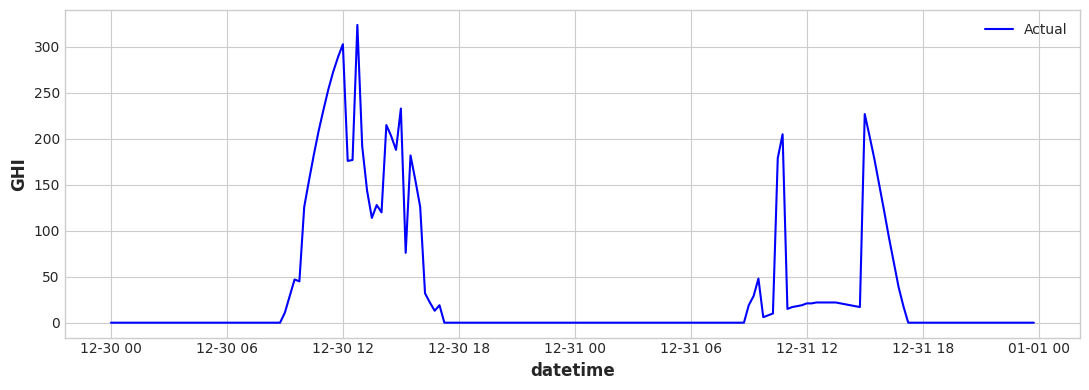

In [83]:
fig, ax = plt.subplots()

# Plot y_ on the set of axes, and specify the label and color for the series
sns.lineplot(data=y_, x=y_.index, y='GHI', ax=ax, label='Actual', color='blue')

# Plot y_pred_ on the same set of axes, and specify the label and color for the series
sns.lineplot(data=y_pred_, x=y_pred_.index, y='GHI', ax=ax, label='Predicted', color='red')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

<Axes: >

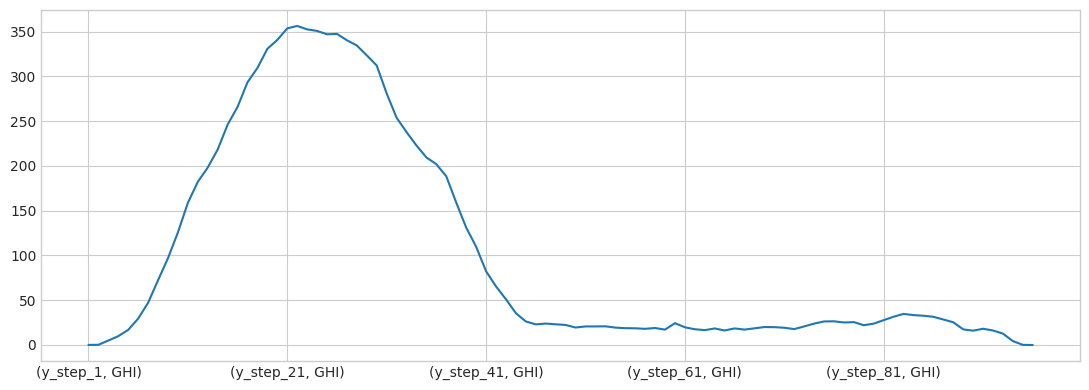

In [84]:
y_pred_.iloc[0].plot()

<Axes: xlabel='datetime'>

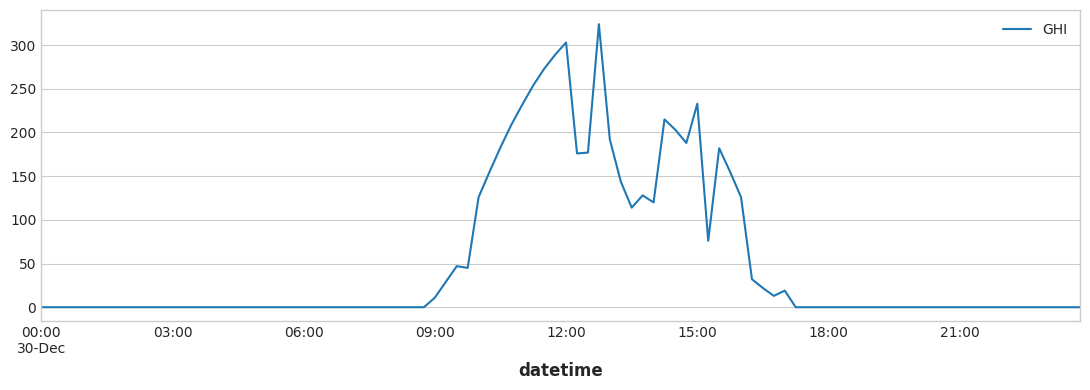

In [90]:
y_[:96].plot()

# Parameters tuning

In [ ]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
#https://lightgbm.readthedocs.io/en/latest/Features.html#leaf-wise-best-first-tree-growth
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_refit_callable.html
#https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
pipeline = Pipeline(steps=[
                      ('scaler', StandardScaler()),  # the first step is to scale the data
                      ("clf", lgbm_reg),
]
              )

param_grid = {"clf__learning_rate" : [0.01, 0.1, 1],
                "clf__num_leaves" : [31, 50, 100],
                "clf__max_depth" : [5, 10, 20],
                "clf__min_child_samples" : [1, 5, 10],
                "clf__subsample" : [0.5, 0.8, 1]}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, 
                    scoring=#[
                        #'neg_mean_absolute_error', 
                        'neg_root_mean_squared_error', 
                        #'max_error', 
                        #'r2',
                            #]
                   )
grid.fit(X.values, y.values)
print(grid.best_score_)
print(grid.cv_results_)